# Models Building in Sports - Part 1

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


%load_ext autoreload
%autoreload 2
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
pd.set_option("max_colwidth", 101)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Case Study - Locate the "zones" of a tennis court

For this we cluster x/y positions.

In [2]:
import courtvisionpython as cvp

In [ ]:
cvp.court()

Let's create a tennis court quickly

In [ ]:
# cvp.utils.get_match(year=2021, matchid="all", event="rg", return_single_dict=False)

In [3]:
# Reading it in:
filename = os.path.join("courtvision_data","australian_open","2021","2021-MS403-ao.json")

In [4]:
match = cvp.read_match(filename)

In [5]:
def norm(val):
    if val <=0:
        val = val * -1
    return val

In [6]:
points_data = match.points_data

bounces = points_data.copy().loc[ (points_data["position"]=="bounce") & (points_data["pointEndType"]!="Ace") & (points_data["pointEndType"]!="Faulty Serve") ]
bounces["x"] = bounces["x"].apply(lambda x: norm(x))

In [7]:
x_y_bounces = bounces[["x","y"]].to_numpy()

### K-means

<Figure size 432x288 with 0 Axes>

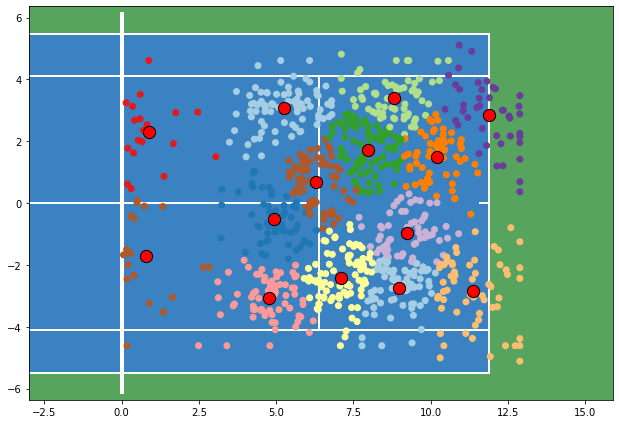

In [8]:
plt.set_cmap('Paired')

fig, ax = cvp.court(surface_color="#56A45D", line_color="white", court_color="#3B82C2", axis=True,equal_aspect=True, aspect="half")

random_state = 170
y_pred = KMeans(n_clusters=14, random_state=random_state).fit(x_y_bounces)

labels = y_pred.labels_
cluster_centers = y_pred.cluster_centers_

ax.scatter(x_y_bounces[:, 0], x_y_bounces[:, 1], c=labels, zorder=10)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="red",s=150, ec="black", zorder=10)

plt.show()

### Heirachical Clustering

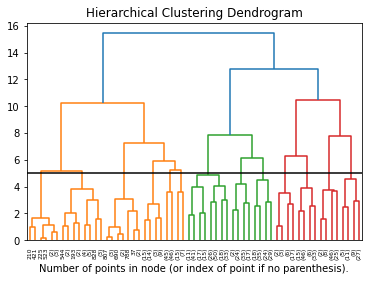

<Figure size 432x288 with 0 Axes>

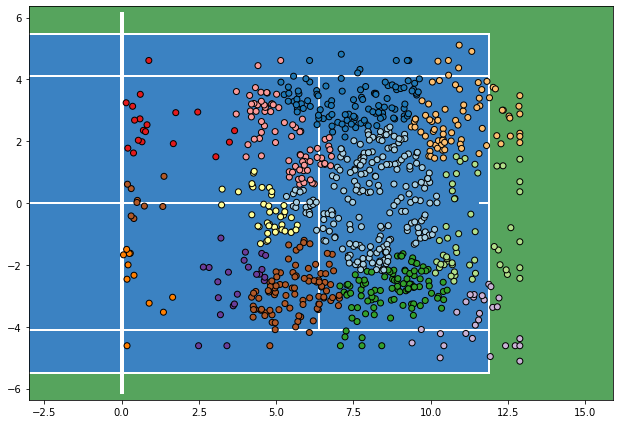

In [10]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
d_threshold = 5
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=d_threshold, n_clusters=None,linkage="complete")

model = model.fit(x_y_bounces)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.hlines(d_threshold,0,1000,color="k")
plt.show()

plt.set_cmap('Paired')

fig, ax = cvp.court(surface_color="#56A45D", line_color="white", court_color="#3B82C2", axis=True,equal_aspect=True, aspect="half")
ax.scatter(x_y_bounces[:, 0], x_y_bounces[:, 1], c=model.labels_,zorder=10,ec="black")

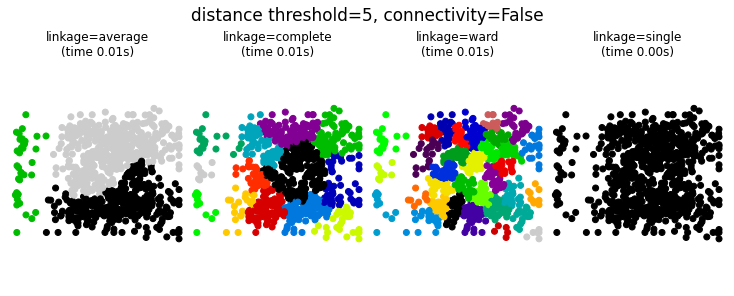

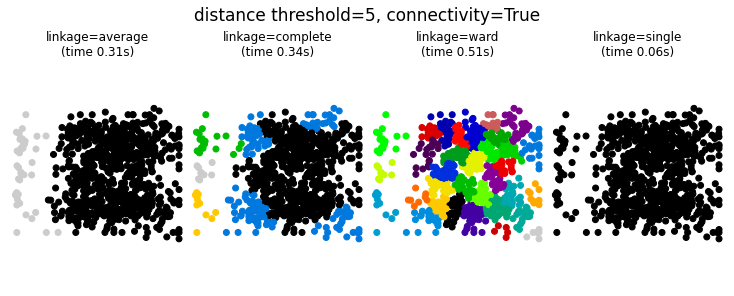

In [33]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

X = x_y_bounces

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 200, include_self=True)

knn_graph

for connectivity in (None, knn_graph):
    for d_threshold in (5,):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward',
                                         'single')):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            distance_threshold=d_threshold,
                                            affinity='euclidean',
                                            n_clusters=None)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.8, wspace=0,
                                left=0, right=1)
            plt.suptitle('distance threshold=%i, connectivity=%r' %
                         (d_threshold, connectivity is not None), size=17)


plt.show()